# Experimental Setup & First Look

We have downloaded the **Enquête emploi en continu 2005** database from the [INSEE website](https://www.insee.fr/fr/statistiques/2415450?sommaire=2415511#titre-bloc-15). The database is in dBASE format and split into three parts (`indiv20051`, `indiv20052`, `indiv20053`), in addition to the `varmod` and `varlist` tables.

Because the dBASE format is inconvenient to work with, we import the contents of these three files into an SQLite databases using the [`dbf2sqlite`](https://github.com/olemb/dbfread/blob/master/examples/dbf2sqlite) script, with the following command:

    ./dbf2sqlite --encoding=cp850 -o ee-insee-2003-2015.sqlite indiv20051.dbf indiv20052.dbf indiv20053.dbf indiv2005_varlist.dbf indiv2005_varmod.dbf

After converting the database into SQLite format, we merged the `indiv2005[1,2,3]` tables into a single `eec05` table, and renamed the `indiv2005_[varlist|varmod]` tables to `varlist` and `varmod` for consistency with the 2015 database, using the following SQL commands:

    CREATE TABLE eec05 AS SELECT * FROM indiv20051
    JOIN indiv20052
        ON indiv20051.ident = indiv20052.ident
        AND indiv20051.noi = indiv20052.noi
        AND indiv20051.trim = indiv20052.trim 
    JOIN indiv20053
        ON indiv20051.ident = indiv20053.ident
        AND indiv20051.noi = indiv20053.noi
        AND indiv20051.trim = indiv20053.trim;

    DROP TABLE indiv20051;
    DROP TABLE indiv20052;
    DROP TABLE indiv20053;

    ALTER TABLE indiv2005_varlist RENAME TO varlist;
    ALTER TABLE indiv2005_varmod RENAME TO varmod;

---
## Experimental Setup

### Libraries & Settings

In [1]:
import os              # General OS commands
import numpy as np     # NumPy
import pandas as pd    # Python Data Analysis Library
import zipfile         # Compress/decompress ZIP files
import sqlite3         # SQLite3 Database Driver

import matplotlib.pyplot as plt

In [2]:
# Never truncate columns, display all the data
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

# Display floating-point numbers with 4 decimals in `pandas.DataFrame`
pd.options.display.float_format = '{:,.4f}'.format

# Display MatPlotLib stuff inline
%matplotlib inline

### Helpers

In [3]:
# Helper function to display nice dictionaries in HTML
def HTMLIter(iter_):
    items = iter_ if isinstance(iter_, list) else iter_.iteritems()
    html = []
    for key, value in items:
        html.append("<tr>")
        html.append("<td><strong>{0}</strong></td>".format(key))
        html.append("<td>{0}</td>".format(value))
        html.append("</tr>")
    html.append("</table>")
    return HTML(''.join(html))

### Database

The resulting SQLite database weighs about 89MB, which is too large for GitHub (our version control repository), so we compressed the database and decompress it on-the-fly before each experiment.

In [4]:
zip_filename = "../../data/ee-insee-2005-sqlite.zip"
eedb = zip_filename.replace("-sqlite.zip", ".sqlite")

if not os.path.exists(eedb):
    with zipfile.ZipFile(zip_filename) as zip_file:
        zip_file.extractall("../../data/")

---
## First look

### Variables
We first look at the list of variables to find out what kind of data we have access to. The variables (i.e. the columns of the main table `eec05`) and their labels are stored in the `varlist` table.

In [5]:
with sqlite3.connect(eedb) as con:
    query = "SELECT * FROM varlist"
    df = pd.read_sql_query(query, con)

df.columns = ["Variable", "Libellé", "Type", "Longueur"]
HTML(df.to_html(index=False))

Variable,Libellé,Type,Longueur
AAC,Exercice d'une activité professionnelle régulière antérieure,Caractère,1.0000
ACESSE,Circonstance du départ de l'entreprise,Caractère,1.0000
ACESSEP,Circonstance du départ de l'emploi antérieur le plus longuement occupé,Caractère,1.0000
ACONTR,Existence d'un contrat de travail (travail occasionnel),Caractère,1.0000
ACPER,Perception d'allocations chômage,Caractère,1.0000
ACTANC,Activité au sens du BIT selon l'ancienne interprétation (3 postes),Caractère,1.0000
ACTEU,Activité au sens du BIT selon l'interprétation communautaire (3 postes),Caractère,1.0000
ACTEU6,Activité au sens du BIT selon l'interprétation communautaire (6 postes),Caractère,1.0000
ACTEU6CJ,Activité au sens du BIT selon l'interprétation communautaire du conjoint de la personne de référence du ménage,Caractère,1.0000
ACTEU6PR,Activité au sens du BIT selon l'interprétation communautaire de la personne de référence du ménage,Caractère,1.0000


### Survey Data
We first load the `eec05` table into a `pandas` DataFrame for easier manipulation.

In [6]:
with sqlite3.connect(eedb) as con:
    eec05 = pd.read_sql("SELECT * FROM eec05", con)

We look at the actual survey data to get an idea of how much data we are dealing with, and what this data looks like.

In [7]:
HTMLIter([
    ("Observations", eec05.shape[0]),
    ("Men", eec05[eec05.sexe == "1"].shape[0]),
    ("Women", eec05[eec05.sexe == "2"].shape[0]),
    ("Parameters", eec05.shape[1])
])

Observations,282721
Men,133516
Women,149205
Parameters,536


In [8]:
eec05.head()

,aac,acesse,acessep,acontr,acper,actanc,acteu,acteu6,acteu6cj,acteu6pr,...,typc,typmen15,typmen5,typp,typps,typsal,ultj,valpre,valprie,zus
0,1,6,,,,3,3,6,6,6,...,,33,3,,,,,nan,nan,0
1,1,9,6,,,3,3,6,6,6,...,,33,3,,,,,nan,nan,0
2,1,9,,,,3,3,6,,6,...,,11,1,,,,,nan,nan,0
3,1,0,2,,,3,3,6,,6,...,,23,2,,,,,nan,nan,0
4,1,1,,1,,1,1,1,,1,...,,10,1,2,,1,,nan,65.0000,0


---
## Variable description
As our objective is to model employment/unemployment, we take a deeper look into the variables that are available to us. In particular, we identify some variables of interest that we believe would be appropriate parameters in a regression model.

We then try to summarise these variables through (1) **descriptive statistics** (2) **graphical representation**, which gives us better insights into the variables and what they look like.

### Dependent/explained variable
The objective of our model will be to identify the relationship between **employment status** and some parameters that we will choose from the set of variables in the database. As such, the regressor in our model will be a binary variable **employed/unemployed**.

The database provides us with the following data, so we need to figure out which of these is closest to a simple employed/unemployed binary variable:
- **ACTEU**: *Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire*
- **ACTEU6**: *Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire (6 postes)*
- **ACTIF**: *Actif au sens du BIT*
- **ACTOP**: *Actif occupé au sens du BIT*

The possible values for these variables are contained in the `varmod` table and are summarised in the following table (*for simplicity, we choose to ignore **ACTEU6***).

In [9]:
with sqlite3.connect(eedb) as con:
    query = """
        SELECT *
        FROM varmod
        WHERE variable IN ("ACTEU", "ACTIF", "ACTOP")
    """
    df = pd.read_sql_query(query, con)

df.columns = ["Variable", "Modalité", "Libellé"]
HTML(df.to_html(index=False))

Variable,Modalité,Libellé
ACTEU,1,Actif occupé
ACTEU,2,Chômeur
ACTEU,3,Inactif
ACTOP,1,Oui
ACTOP,2,Non


We can take the opportunity to perform a **sanity check** on the data, to ensure both that the data is consistent, and that we have understood these variables properly. To this end, we use the following identities, inferred from the definitions of the variables contained in the `varlist`/`varmod` tables:
- `ACTOP(1) = ACTEU(1)`
- `ACTOP(2) = ACTEU(2) + ACTEU(3)`

In [10]:
varmods = [("ACTEU", [1, 2, 3]), ("ACTOP", [1, 2])]
varmods = [(v[0], m) for v in varmods for m in v[1]]
counts = {vm: eec05[eec05[vm[0].lower()] == str(vm[1])].shape[0] for vm in varmods}
        
print "ACTOP(1): {} | ACTEU(1): {}".format(counts[("ACTOP", 1)], counts[("ACTEU", 1)])
print "ACTOP(2): {} | ACTEU(2) + ACTEU(3): {}".format(counts[("ACTOP", 2)], sum([counts[("ACTEU", 2)], counts[("ACTEU", 3)]]))

ACTOP(1): 137438 | ACTEU(1): 137253
ACTOP(2): 145283 | ACTEU(2) + ACTEU(3): 145468


The sanity check has highlighted some very slight discrepancies. The (small) difference in totals does not *necessarily* mean that only 2 observations are affected: we need to check how many rows are affected and whether this discrepancy can turn out to be problematic.

In [11]:
# Filter the DataFrame to find the problematic rows
masks = [
    (eec05.actop == "1") & (eec05.acteu != "1"),
    (eec05.acteu.isin(["2", "3"]) & ~(eec05.actop == "2"))
]

# Assert both lists (set of indices) are the same
obs = [list(eec05[mask].index) for mask in masks]
assert obs[0] == obs[1]

The affected rows are the same for both masks, so we can safely conclude that these two observations are problematic, but that the rest of the database is safe. We also remove these two observations from the DataFrame for later analyses.

In [12]:
eec05 = eec05[~eec05.index.isin(obs[0])]

The results of our sanity check are now satisfactory, we choose to use **ACTOP** as our (binary) dependent variable:
- **ACTOP = 1**: the observed individual is part of the *population active occupée*
- **ACTOP = 2**: the observed individual is *chômeur* or *inactif*

### Independent/explanatory variables
We choose a few "basic" variables that we (intuitively) think will be part of our regression models:
- **AG**: *Âge détaillé en années révolues au 31 décembre*
- **DIP11**: *Diplôme le plus élevé obtenu (2 chiffres, 11 postes)*
- **SEXE**: *Masculin/Féminin*

In [13]:
basic = eec05[["actop", "ag", "dip11", "sexe"]].copy()    # create a new df subset of the entire database
basic = basic.replace([""], [None]).dropna()    # drop any rows that have NULL, N/A or empty values
for col in ["actop", "sexe"]:
    basic[col] = basic[col].map({"2": 1, "1": 0})
basic = basic.astype(int)    # convert all data to `int` type

We now look at summary statistics and graphical representations for these variables.

In [14]:
basic.describe()

,actop,ag,dip11,sexe
count,"282,410.0000","282,410.0000","282,410.0000","282,410.0000"
mean,0.5144,46.9019,51.2863,0.5278
std,0.4998,19.5938,18.9158,0.4992
min,0.0000,15.0000,10.0000,0.0000
25%,0.0000,31.0000,41.0000,0.0000
50%,1.0000,46.0000,50.0000,1.0000
75%,1.0000,61.0000,70.0000,1.0000
max,1.0000,99.0000,71.0000,1.0000


Our initial graphical representation simply plots (`param`, `actop`) on a scatter plot. Because `actop` only takes values from `{0, 1}`, the points are superposed and we cannot have an idea of the magnitude/count of `{0, 1}`s.

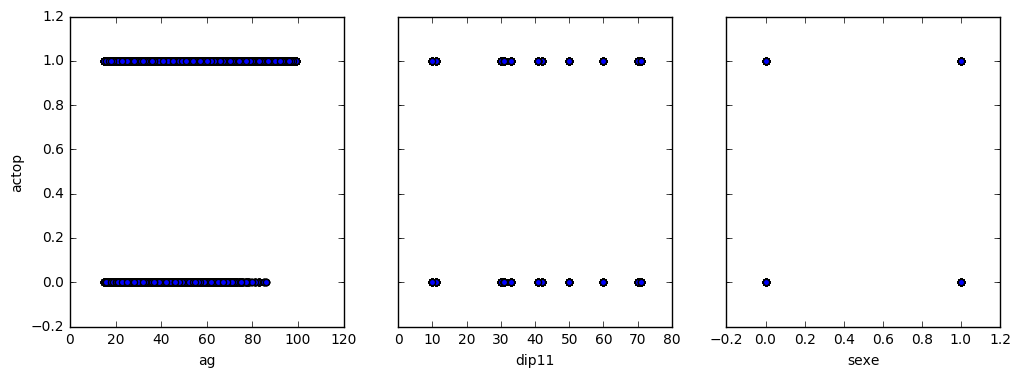

In [15]:
params = [_ for _ in basic.columns if _ != "actop"]
figure, x_axis = plt.subplots(1, len(params), figsize=(12, 4), sharey=True)
for ix, param in enumerate(params):
    basic.plot.scatter(x=param, y="actop", ax=x_axis[ix])

In order to get a better idea of what is going on, we add some "noise" to the `actop` values. We calculate the noise based on the expected value of `actop` conditional on `x` being equal to one of the possible categories, i.e.:

$$P(y=1 | x=k, X_{-1})$$

**TODO**:
- what you're doing below is no different than just showing the mean
- change the plot to add noise to both x and y axes
- take a small sample (e.g. 1000 observations) to get a better idea
- also, display the mean as a line

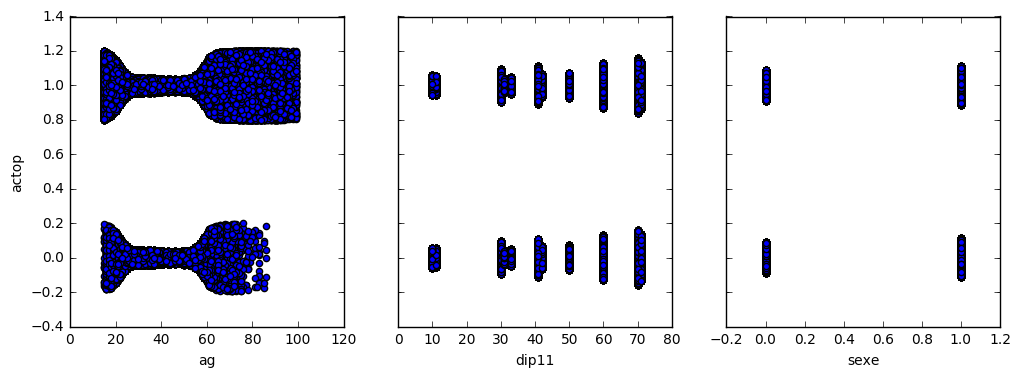

In [16]:
params = [_ for _ in basic.columns if _ != "actop"]
xy = {}

figure, x_axis = plt.subplots(1, len(params), sharey=True, figsize=(12, 4))

# Create a new DataFrame(param, noisy("actop")) for each of the parameters of interest
# and store this DataFrame in the `xy` dictionary.
for ix, param in enumerate(params):
    xy[param] = basic[[param, "actop"]].copy()
    
    # Calculate mean value of `actop` for each `param` category
    # Note: mean(actop) is the probability of employment for a given category
    means = xy[param].groupby(param).mean()

    # Scale down the means to be in [0, 0.2], such that the points
    # are contained in a circle with radius 0.2 around y=0 and y=1
    means *= 0.2

    # Generate a "noise" Series from a uniform distribution with range [-mean, mean]
    # Take the `params` column of observations, map the appropriate mean
    # then apply the `uniform` function to the mean
    meansd = means["actop"].to_dict()
    eps = xy[param][param].map(meansd)
    eps = eps.apply(lambda x: np.random.uniform(-x, x))
    
    # Add the `epsilon` and (original) `actop` vectors
    xy[param]["actop"] += eps

    # For each `param`, we now have a DataFrame that maps `param`-value to `noisy(actop)`,
    # and we are ready to plot the noisy version of the chart, using the `figure` object
    # created above
    xy[param].plot.scatter(x=param, y="actop", ax=x_axis[ix])

---
## Custom Database

We now build a custom subset of the original `eec05` database and export it in SQL format. The purpose of this is **(1)** to enable other team members to work on a clean & small subset with other languages (e.g. `R`), and **(2)** to perform the work of cleaning the database here once and for all, and enable loading the custom version in separate notebooks.

We perform some transformations and cleaning on the loaded subset. In particular, we:
1. drop any observations that contain any `NULL` or `N/A` values
2. convert all values from generic `object` types to the `int` type (note that `pandas` will automatically cast from `int` to `float` when required)
3. transform the original categorical variables into a set of purely binary variables

**Note**: we keep the original variables and label the transformed (binary) ones with an extra "`_`" (e.g. `dip` vs. `dip31_`)

In [17]:
# Create a subsetted copy of the original `eec05` DataFrame
params = [
    "ident", "noi", "trim",                            # identifiants
    "age", "sexe", "actop",                            # individu
    "lnais", "lnaisp", "nat28",                        # lieu de naissance/nationalité
    "cohab", "matri", "nbenf18", "so", "typmen5",      # ménage
    "dip", "spe",                                      # éducation
#     "dipsup", "diptec", "dipgen",
#     "spegen", "spetec", "spesup",
    "cstot", "cspm", "cspp",                           # catégorie socio-professionelle
    "reg", "tur5", "zus",                              # géographie
    "naim",                                            # autres
]
eec05_custom = eec05[params].copy()

# SPE: spécialité du diplôme le plus élevé
#  - drop any "non renseigné" observations ("000")
#  - then replace "" with "000" for "no diploma"
eec05_custom = eec05_custom[eec05_custom.spe != "000"]
eec05_custom["spe"] = eec05_custom["spe"].replace("", "000")

# MATRI: Statut matrimonial légal
#  - replace "" with "0" for < 15 year old
eec05_custom["matri"] = eec05_custom["matri"].replace("", "0")

# Drop any observations that contain any NULL, N/A or empty values
eec05_custom = eec05_custom.replace([""], [None]).dropna()

# Convert all values from generic objects to the `int` type
eec05_custom[params[1:]] = eec05_custom[params[1:]].astype(int)

# Transform categorical variables into a set of purely binary variables
## ACTOP: (1, 2) -> (0, 1)
eec05_custom["actop_"] = eec05_custom["actop"].map({1: 0, 2: 1})

## SEXE: create FEMALE_ = (1,2) -> (0,1), MALE_ = ~FEMALE
eec05_custom["female_"] = eec05_custom["sexe"].map({1: 0, 2: 1})
eec05_custom["male_"] = (~eec05_custom["female_"].astype(bool)).astype(int)

## LNAIS: create LNETR_ = (1,2) -> (0,1), LNFRA_ = ~LNETR_
eec05_custom["lnetr_"] = eec05_custom["lnais"].map({1: 0, 2: 1})
eec05_custom["lnfra_"] = (~eec05_custom["lnetr_"].astype(bool)).astype(int)

## LNAISP: create LNETRP_ = (1,2,3) -> (0,1,1), LNFRAP_ = ~LNETRP_
## we are merging 2 & 3 (assume "don't know" ==> "born abroad"), 
eec05_custom["lnetrp_"] = eec05_custom["lnaisp"].map({1: 0, 2: 1, 3: 1})
eec05_custom["lnfrap_"] = (~eec05_custom["lnetrp_"].astype(bool)).astype(int)

## COHAB: create VIE_COUPLE_ = (2,1) -> (0,1)
eec05_custom["vie_couple_"] = eec05_custom["cohab"].map({1: 1, 2: 0})

## ZUS: nothing to do, create ZUS_
eec05_custom["zus_"] = eec05_custom["zus"]

## split into __{__}
categorical = ["nat28", "matri", "nbenf18", "so", "typmen5", "dip", 
               "spe", "cstot", "cspm", "cspp", "reg", "tur5", "naim"]

for col in categorical:
    for x in list(set(eec05_custom[col].get_values())):
        eec05_custom["{}_{}_".format(col, x)] = np.where(eec05_custom[col] == x, 1, 0)

Finally, we export the new DataFrame in SQLite format and compress it for later use.

In [18]:
eedb_custom = "../../data/ee-insee-2005_custom.sqlite"

# Export to SQLite
with sqlite3.connect(eedb_custom) as con:
    eec05_custom.to_sql(name="eec05_custom", con=con, index=False, if_exists="replace")

# Compress the SQLite file
zip_filename = eedb_custom.replace(".sqlite", "-sqlite.zip")
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zip_file:
    zip_file.write(eedb_custom, os.path.basename(eedb_custom))